In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
np.set_printoptions(legacy='1.25')
import os
import warnings
from functions import *
warnings.filterwarnings('ignore', category=FutureWarning)

## Poshmark Data Analytics: EDA

This project aims to explore what's selling on Poshmark, sell-through rates for specific products, and the best brands and products to source for resellers on Poshmark. Data was ethically sourced through web-scraping on Poshmark with a script that follows the site's scraping guidlines outlined in the **Robots.txt** file.

The data contains information about sold listings on Poshmark. I chose a few popular categories to scrape and do analyses on instead of selecting from all sold listings on Poshmark, as I wanted to focus on Women's clothing and exclude home and makeup items from the analysis. The categories are: tops, dresses, bags, jeans and skirts.

*For privacy protection, my scraping script is located in a separate directory, and I will remove usernames and the links to specific products from the dataframes before analyses; these columns were used as primary keys to identify unique listings but are not necessary for the data analysis.*

### 1. Opening the Files

In [34]:
tops = pd.read_csv(os.path.expanduser('~/Desktop/data/listings-tops.csv'))
skirts = pd.read_csv(os.path.expanduser('~/Desktop/data/listings-skirts.csv'))
jeans = pd.read_csv(os.path.expanduser('~/Desktop/data/listings-jeans.csv'))
bags = pd.read_csv(os.path.expanduser('~/Desktop/data/listings-bags.csv'))
dresses = pd.read_csv(os.path.expanduser('~/Desktop/data/listings-dresses.csv'))

dfs = [tops, skirts, jeans, bags, dresses]

In [35]:
for df in dfs:
    df.drop(columns = ['link','user'], inplace=True)

In [36]:
tops

,name,sold price,original price,post_date,size,brand,categories,color(s),sold date,nwt,boutique
0,PLUS WASHED SHORT SLEEVE TOP WITH POCKETS 1 XL,$15,NaN,2025-04-26,1X,Zenana Outfitters,"['Women', 'Tops']","['Green', 'Blue']",05-28-2025,0.0,NaN
1,Rebuy,$3,NaN,2024-02-03,M,NaN,"['Women', 'Tops']",['White'],05-28-2025,0.0,NaN
2,Women’s NWT Dog Paw Print T-Shirt,$20,$25,2024-12-27,XL,NaN,"['Women', 'Tops']","['Blue', 'White']",05-28-2025,1.0,NaN
3,Johnny Was Womens Bee Active Polo T-Shirt,$90,$165,2025-05-28,S,Johnny Was,"['Women', 'Tops']",[],05-28-2025,0.0,NaN
4,"Women's Classic Black, Blue, and Tan Tops- A N...",$15,NaN,2025-05-09,S,Threshold,"['Women', 'Tops']","['Black', 'Blue']",05-28-2025,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
12568,"Peace Lgbt Graphics Tee, Gay Pride T-shirt",$14,$28,2025-05-26,XL,NaN,['tops'],[],06-04-2025,0.0,0.0
12569,Vuori Pose Fitted Tee. In size medium and Azur...,$34,$58,2025-06-03,M,Vuori,['tops'],[],06-04-2025,0.0,0.0
12570,Plus Fuchsia & Navy Zigzag Chevron Lace Yoke C...,$17,NaN,2023-01-25,2X,Haptics,['tops'],"['navy', 'tan', 'fuchsia']",06-04-2025,0.0,1.0
12571,Warning: May Cause Excessive Joy! GAME NIGHT E...,$20,$123,2024-07-18,077,torrid,['tops'],[],06-04-2025,1.0,0.0


### 2. Data Description

Columns:

1. **name**: The name of the listing as it appears on the listing's title.

2. **sold price**: The price the item sold for on Poshmark.

3. **original price**: The price the seller indicated was the original retail price of the item. 
    -- *Limitations:* This information may be inaccurate as it is user-provided, and some listings do not specify an original price.

4. **post_date**: The date the listing was sold to a buyer.

5. **size**: Size of the garmet if applicable.

6. **brand**: Brand of the garmet if applicable.

7. **categories**: Categories of the item.

8. **color(s)**: Colors of the item as outlined in the name. 
    -- *Limitations:* The color is only added to this list if there are mentions of a color in the name.

9. **sold_date**: The inferred sold date of the listing.
    -- *Limitations:* The sold date is inferred based on when the listing was added to the recently sold items page.

10. **nwt**: Whether an item is "New with Tags". 

11. **boutique**: Whether an item was sold from a Boutique, which is a shop that resells clothing sourced from wholesalers rather than used clothing or clothing sourced elsewhere.

In [37]:
tops.columns

Index(['name', 'sold price', 'original price', 'post_date', 'size', 'brand',
       'categories', 'color(s)', 'sold date', 'nwt', 'boutique'],
      dtype='object')

### 3. Data Cleaning

*Cleaning Tasks:*
* Convert numeric columns to correct datatypes.
* Explode the color column for color analyses.
* Convert dates to datetime objects.

In [38]:
for df in dfs:
    df['sold price'] = df['sold price'].str.replace(',','').str.strip('$').astype('Int64')
    df['original price'] = df['original price'].str.replace(',','').str.strip('$').astype('Int64') 
    df['sold date'] = pd.to_datetime(df['sold date'], format='%m-%d-%Y', errors='coerce')
    df['post_date'] = pd.to_datetime(df['post_date'], format='%Y-%m-%d', errors='coerce')

In [39]:
tops.head(5)

,name,sold price,original price,post_date,size,brand,categories,color(s),sold date,nwt,boutique
0,PLUS WASHED SHORT SLEEVE TOP WITH POCKETS 1 XL,15,<NA>,2025-04-26,1X,Zenana Outfitters,"['Women', 'Tops']","['Green', 'Blue']",2025-05-28,0.0,NaN
1,Rebuy,3,<NA>,2024-02-03,M,NaN,"['Women', 'Tops']",['White'],2025-05-28,0.0,NaN
2,Women’s NWT Dog Paw Print T-Shirt,20,25,2024-12-27,XL,NaN,"['Women', 'Tops']","['Blue', 'White']",2025-05-28,1.0,NaN
3,Johnny Was Womens Bee Active Polo T-Shirt,90,165,2025-05-28,S,Johnny Was,"['Women', 'Tops']",[],2025-05-28,0.0,NaN
4,"Women's Classic Black, Blue, and Tan Tops- A N...",15,<NA>,2025-05-09,S,Threshold,"['Women', 'Tops']","['Black', 'Blue']",2025-05-28,0.0,NaN


## 4. Top Performing Brands

Identifying the top-performing brands based on popularity.

In [40]:
# top 10 brands by number of sold listings
top_brands = tops['brand'].value_counts().head(12).index
popular_brand_df = tops[tops['brand'].isin(top_brands)]

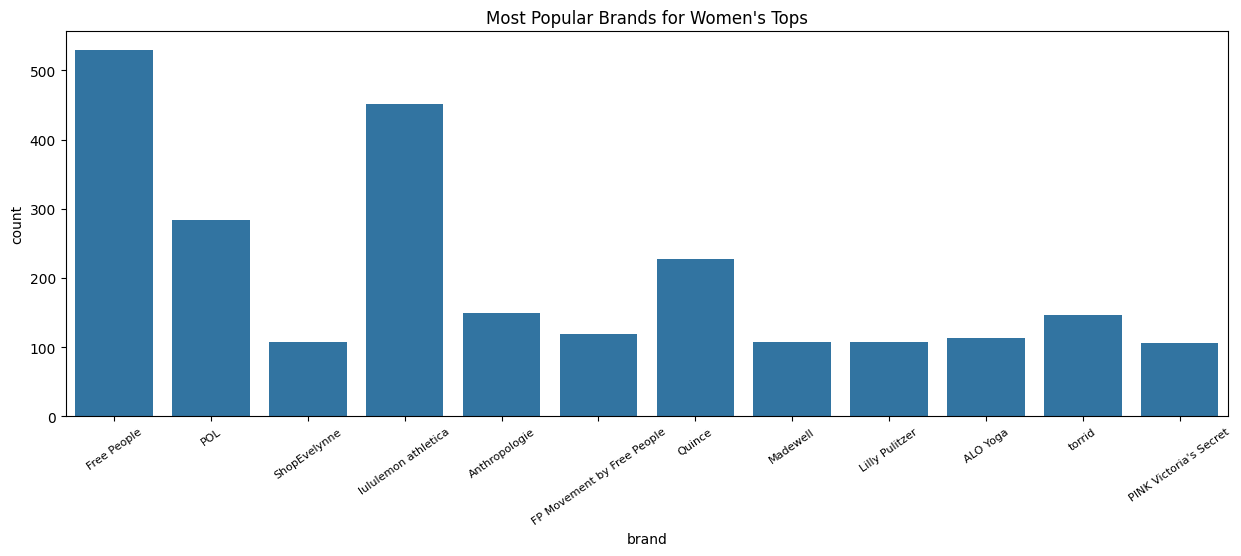

In [41]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=35, fontsize=8)
plt.title("Most Popular Brands for Women's Tops")

ax = sns.countplot(data=popular_brand_df, x='brand')

### 5. Brands with Quickest Sell-through Rate

Identifying the brands that sell the fastest, on average.

In [56]:
tops['days to sell'] = (tops['sold date'] - tops['post_date']).dt.days

In [62]:
def avg_days_to_sell_by_brand(df, num_brands, min_sales, category):    
    
    brand_counts = df['brand'].value_counts()
    brands_over_min_sales = brand_counts[brand_counts > min_sales].index

    tops_filtered = tops[tops['brand'].isin(brands_over_min_sales)].sort_values(by='days to sell', ascending=True)

    fastest_brands = tops_filtered.groupby('brand')['days to sell'].agg('mean').sort_values(ascending=True).reset_index()

    top_fastest = fastest_brands[:num_brands]

    plt.figure(figsize=(15, 6))
    sns.barplot(data=top_fastest, x='days to sell', y='brand', palette='viridis')

    plt.title(f"Top {num_brands} Brands with Lowest Average Days to Sell in Women's {category} (Brands with >{min_sales} Listings)")
    plt.xlabel('Average Days to Sell')
    plt.xticks(fontsize=9)
    plt.ylabel('Brand')

    plt.tight_layout()
    plt.show()


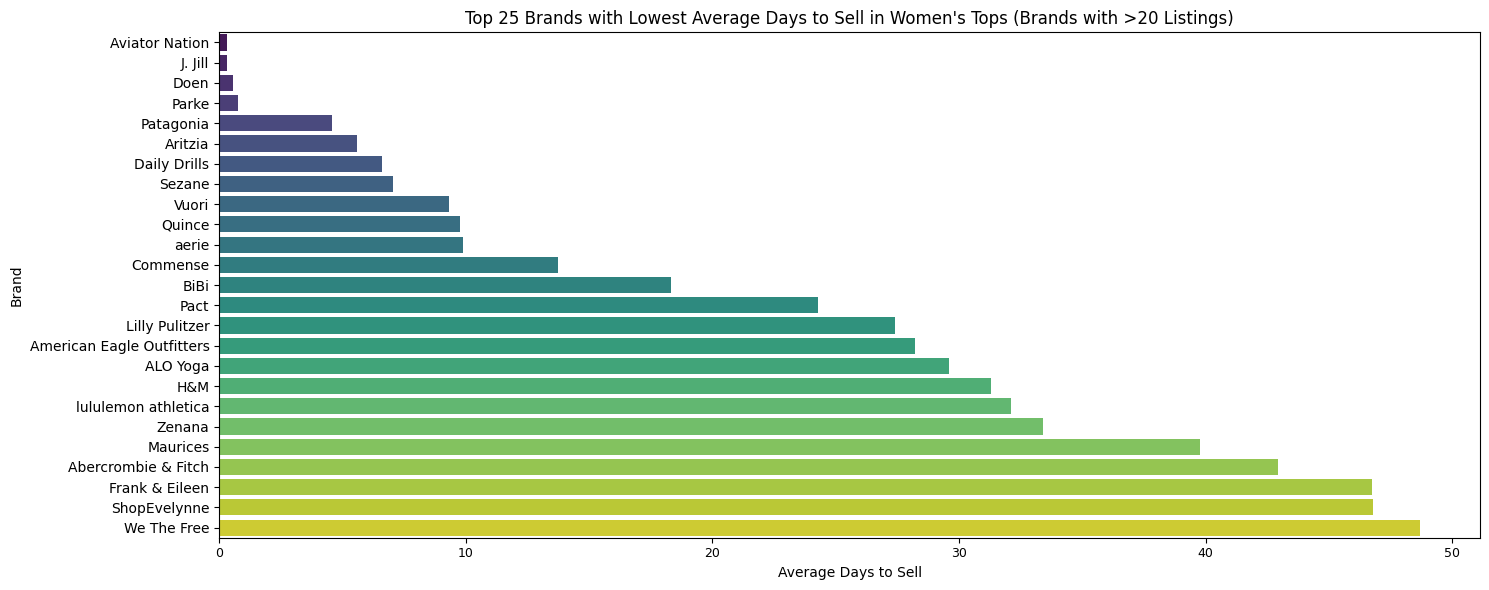

In [66]:
avg_days_to_sell_by_brand(tops, 25, 20, 'Tops')

#### *Removing Outliers*

A top-selling brand, *Free People*, is not included in the quickest days to sell although some of its child-brands, *FP Movement by Free People* and *We The Free* are. This indicates that there may be some extreme outliers in the 'days to sell' column, which should be removed for a better visualization.

Text(0.5, 1.0, 'Days to sell Free People tops')

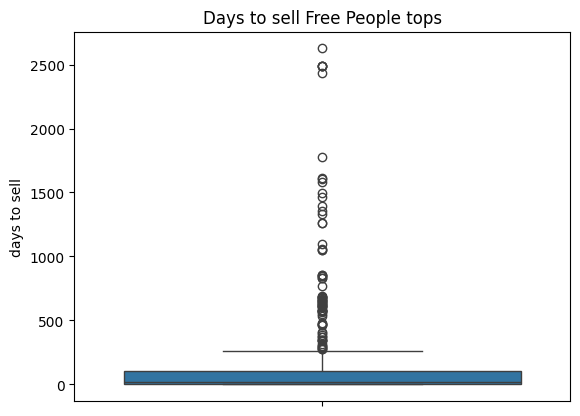

In [72]:
# visualizing the outliers for Free People
sns.boxplot(tops[tops['brand'] == 'Free People']['days to sell'])
plt.title("Days to sell Free People tops")

Based on the boxplot, the tail of outliers going into the 1000+ days to sell range may be weighing down the average.

Text(0.5, 1.0, 'Days to sell Free People tops, outliers removed')

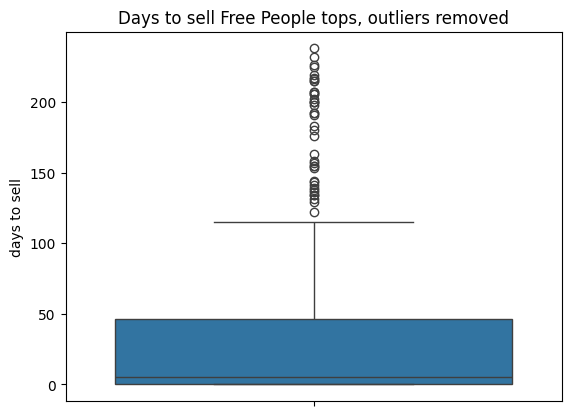

In [71]:
filtered_tops = remove_outliers_iqr(tops, 'days to sell')
sns.boxplot(filtered_tops[filtered_tops["brand"]=="Free People"]["days to sell"])
plt.title('Days to sell Free People tops, outliers removed')

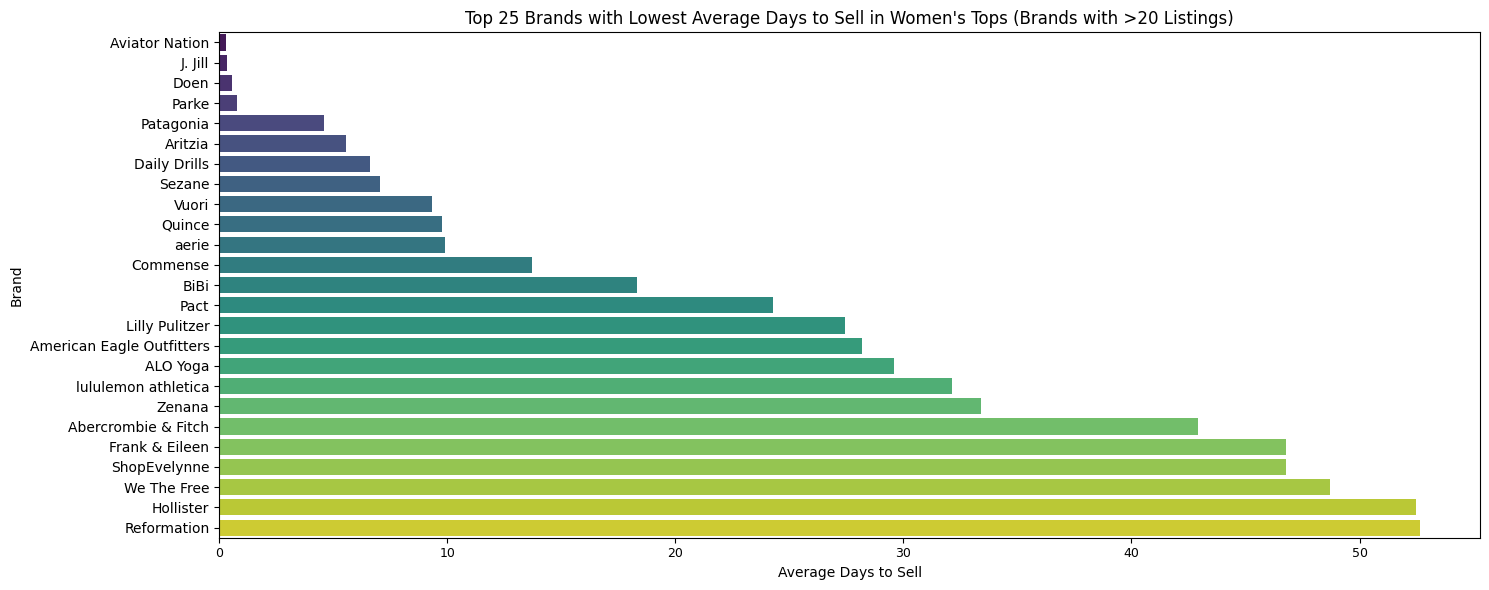

In [69]:
avg_days_to_sell_by_brand(filtered_tops, 25, 20, 'Tops')

Removing outliers via IQR did not add *Free People* to the top-selling brands, indicating *Free People* is a popularly purchased brand, but it takes longer to sell compared to other popular brands. This could be important for someone sourcing inventory for their shop, as prioritizing quick-to-sell brands may align more with their shop goals.